In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-90540cb8-08ee-4a65-a667-e53896082b98',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'PKZqQ-rSgkiw_RCWV9eYzhmgW3x_GVcmKoRyxAAYV--N'
}

configuration_name = 'os_ec92bdccebee408780712b1ccdacfd14_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option("inferSchema", 'true') \
  .option('header', 'true')\
  .option("delimiter", "|")\
  .load(cos.url('HARData.csv', 'bdpp-donotdelete-pr-na9vgpo95xobmc'))
#df_data_2.take(1)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200510191311-0000
KERNEL_ID = 1ea91cf8-2127-4376-9ac7-5b7b951b9218


In [3]:
df_data_2.describe(["tBodyAcc-mean()-X"]).show()

+-------+-------------------+
|summary|  tBodyAcc-mean()-X|
+-------+-------------------+
|  count|               7352|
|   mean|0.27448812496352026|
| stddev|0.07026133266614945|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



In [17]:
df_data_2.printSchema()

root
 |-- tBodyAcc-mean()-X: double (nullable = true)
 |-- tBodyAcc-mean()-Y: double (nullable = true)
 |-- tBodyAcc-mean()-Z: double (nullable = true)
 |-- tBodyAcc-std()-X: double (nullable = true)
 |-- tBodyAcc-std()-Y: double (nullable = true)
 |-- tBodyAcc-std()-Z: double (nullable = true)
 |-- tBodyAcc-mad()-X: double (nullable = true)
 |-- tBodyAcc-mad()-Y: double (nullable = true)
 |-- tBodyAcc-mad()-Z: double (nullable = true)
 |-- tBodyAcc-max()-X: double (nullable = true)
 |-- tBodyAcc-max()-Y: double (nullable = true)
 |-- tBodyAcc-max()-Z: double (nullable = true)
 |-- tBodyAcc-min()-X: double (nullable = true)
 |-- tBodyAcc-min()-Y: double (nullable = true)
 |-- tBodyAcc-min()-Z: double (nullable = true)
 |-- tBodyAcc-sma(): double (nullable = true)
 |-- tBodyAcc-energy()-X: double (nullable = true)
 |-- tBodyAcc-energy()-Y: double (nullable = true)
 |-- tBodyAcc-energy()-Z: double (nullable = true)
 |-- tBodyAcc-iqr()-X: double (nullable = true)
 |-- tBodyAcc-iqr()-Y: do

In [18]:
len(df_data_2.columns)

563

In [19]:
df_data_2.count()

7352

# Visualization Analysis

In [30]:
import matplotlib.pyplot as plt

In [8]:
df_data_2.groupBy('activity').count().show()

+--------+-----+
|activity|count|
+--------+-----+
|walkdown|  986|
| sitting| 1286|
|  walkup| 1073|
|standing| 1374|
|  laying| 1407|
|    walk| 1226|
+--------+-----+



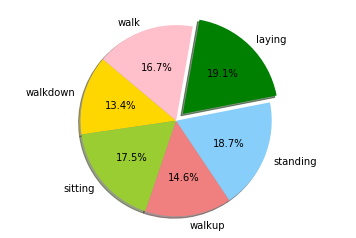

In [56]:
# Data to plot
labels = 'walkdown', 'sitting', 'walkup', 'standing', 'laying', 'walk'
sizes = [986, 1286, 1073, 1374, 1407,1226]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'green','pink']
explode = (0, 0, 0, 0, 0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

345 213 5


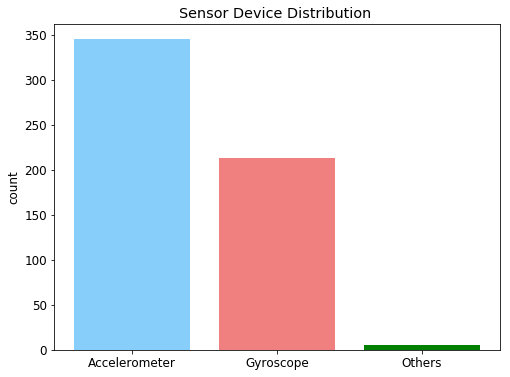

In [47]:
#What is the distribution of activities being captured by devices?

# Count for each type
def count_type(col):
    acc, gyro, others = 0, 0, 0
    for columns in col.columns:
        if 'Acc' in str(columns):
            acc += 1
        elif 'Gyro' in str(columns):
            gyro+= 1
        else:
            others+= 1
    return acc, gyro, others
# Show bar plot for the three types
acc, gyro, others = count_type(df_data_2)
plt.rcParams.update({'figure.figsize': [8, 6], 'font.size': 12})
plt.bar(['Accelerometer', 'Gyroscope', 'Others'], [acc, gyro, others], color = ('lightskyblue', 'lightcoral', 'green'))
plt.title("Sensor Device Distribution ")
plt.ylabel("count")
print(acc, gyro, others)

In [9]:
df_y = df_data_2.select('activity')
df_y.take(5)

[Row(activity='standing'),
 Row(activity='standing'),
 Row(activity='standing'),
 Row(activity='standing'),
 Row(activity='standing')]

In [49]:
cols = list(set(df_data_2.columns) - {'subject','activity'})
df_X = df_data_2.select(cols)
len(df_X.columns)

561

In [50]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=cols,
    outputCol="features")

dfAttrs = assembler.transform(df_X)
dfAttrs.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[-0.77111201,-0.9...|
|[-0.14992836,-0.9...|
|[-0.16564496,-0.9...|
|[-0.20718879,-0.9...|
|[-0.33952923,-0.9...|
+--------------------+
only showing top 5 rows



In [136]:
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(dfAttrs)
    cost[k] = model.computeCost(dfAttrs) # requires Spark 2.0 or later

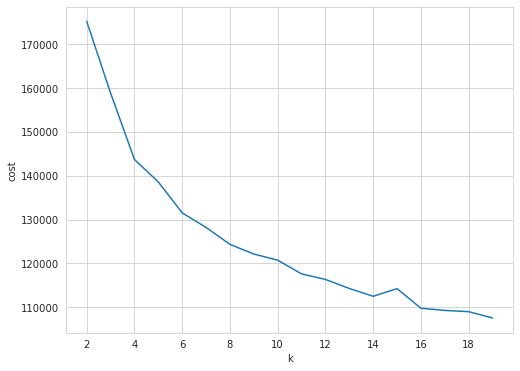

In [139]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
plt.xlabel('k')
plt.ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [135]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dfAttrs)

# Make predictions
predictions = model.transform(dfAttrs)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7199401660871235
Cluster Centers: 
[ 0.3  -0.34 -0.11 -0.11 -0.73 -0.97 -0.28 -0.3  -0.26 -0.37  0.76 -0.58
 -0.38 -0.22 -0.11 -0.92 -0.2   0.13  0.24 -0.64 -0.68 -0.71 -0.55 -0.78
  0.1   0.02 -0.05 -0.08  0.6  -0.3  -0.2  -0.76 -0.71 -0.37  0.03 -0.64
 -0.64 -0.37 -0.22 -0.71 -0.6  -0.45 -0.26 -0.73 -0.7  -0.81 -0.77 -0.64
 -0.92 -0.77 -0.32  0.58 -0.81 -0.71 -0.65  0.52 -0.26  0.14 -0.89 -0.22
 -0.67 -0.41 -0.96 -0.28  0.13  0.45 -0.41 -0.52 -0.13 -0.21 -0.59 -0.75
 -0.31 -0.38  0.37 -0.47  0.01 -0.78 -0.81 -0.53 -0.67 -0.29  0.41 -0.91
 -0.84 -0.05 -0.59  0.26 -0.71 -0.04 -0.28  0.26 -0.49 -0.51 -0.26 -0.94
 -0.77 -0.81 -0.37 -0.39 -0.67 -0.37 -0.96 -0.14 -0.6  -0.57 -0.69 -0.37
 -0.81  0.84 -0.35 -0.56 -0.25 -0.65 -0.9  -0.03 -0.05 -0.42 -0.46  0.23
 -0.53 -0.48 -0.74 -0.02 -0.    0.17 -0.67 -0.89  0.57 -0.89 -0.86  0.56
 -0.82 -0.94 -0.94  0.   -0.49 -0.41 -0.78  0.15 -0.6   0.17 -0.6   0.17
  0.04  0.08 -0.51  0.04 -0.01 -0.54 -0.03

In [17]:
from pyspark.ml.stat import Correlation

r1 = Correlation.corr(dfAttrs,"features").head()

print("correlation matrix:\n" + str(r1[0]))

correlation matrix:
DenseMatrix([[ 1.        ,  0.18891765,  0.67124246, ...,  0.85415498,
              -0.77076734,  0.33877726],
             [ 0.18891765,  1.        ,  0.08960043, ...,  0.12756836,
              -0.04306028,  0.19912261],
             [ 0.67124246,  0.08960043,  1.        , ...,  0.67072614,
              -0.5964    ,  0.22792176],
             ...,
             [ 0.85415498,  0.12756836,  0.67072614, ...,  1.        ,
              -0.93022416,  0.3142758 ],
             [-0.77076734, -0.04306028, -0.5964    , ..., -0.93022416,
               1.        , -0.28416402],
             [ 0.33877726,  0.19912261,  0.22792176, ...,  0.3142758 ,
              -0.28416402,  1.        ]])


In [49]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    #plt.figure(figsize=(50,50))
    ax=fig.add_subplot(111)
    #ax.set_title("Correlation Matrix for All Attributes")
    ax.set_yticklabels(['']+attr)
    ax.set_xticklabels(['']+attr, rotation=90)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

In [19]:
matrix = Correlation.corr(dfAttrs,"features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()

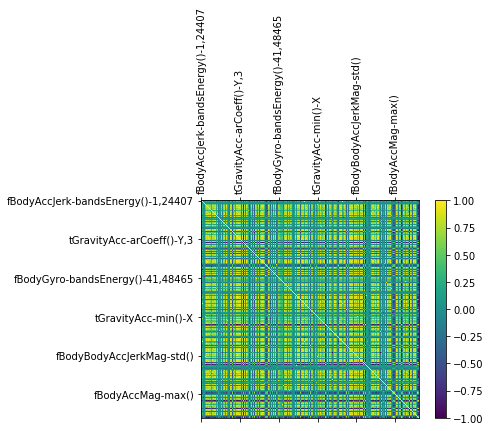

In [50]:
plot_corr_matrix(corrmatrix, cols, 1)

In [52]:
df = spark.createDataFrame(corrmatrix,cols)

In [53]:
df.collect()[0][0]

1.0

In [36]:
colsvar = {}
for f in cols:
    # compute standard deviation of column 'f'
    std = float(df_X.describe(f).filter("summary = 'stddev'").select(f).collect()[0].asDict()[f])        
    # compute variance
    var = std*std
    colsvar[f]=var

In [51]:
sort_var = sorted(colsvar.items(), key=lambda item: item[1])

In [42]:
sort_var[:10]

[('tBodyAcc-mean()-Y', 0.0016654989159449417),
 ('tBodyAcc-mean()-Z', 0.0032075445293926626),
 ('fBodyAccJerk-bandsEnergy()-57,64388', 0.0033671848974308172),
 ('fBodyGyro-bandsEnergy()-33,40478', 0.0041923001143639145),
 ('fBodyGyro-bandsEnergy()-33,40492', 0.004286686131851696),
 ('fBodyGyro-bandsEnergy()-33,48498', 0.0046663927136306686),
 ('tBodyAcc-mean()-X', 0.00493665486802332),
 ('fBodyGyro-bandsEnergy()-33,48484', 0.005119178023149137),
 ('fBodyGyro-bandsEnergy()-25,48501', 0.005165237164451425),
 ('tGravityAcc-iqr()-X', 0.005377669364063185)]

In [44]:
sort_var[-10:]

[('fBodyAccMag-entropy()', 0.46609320821332495),
 ('tGravityAcc-correlation()-X,Y', 0.48530192374233366),
 ('tGravityAcc-energy()-X', 0.48706973349043636),
 ('tBodyGyroJerkMag-entropy()', 0.4951603869929768),
 ('tGravityAcc-correlation()-Y,Z', 0.4958434606834776),
 ('tGravityAcc-correlation()-X,Z', 0.5008732747058472),
 ('fBodyAcc-entropy()-X', 0.5257171797794952),
 ('tBodyAccJerkMag-entropy()', 0.5289137561123618),
 ('fBodyAccJerk-entropy()-Y', 0.5425036587260853),
 ('fBodyAccJerk-entropy()-X', 0.5651023454960704)]

In [24]:
import matplotlib.pyplot as plt

In [15]:
#walkdown sitting walkup standing laying walk
df_walkdown = df_data_2.filter(df_data_2['activity']=='walkdown')
#df_walkdown.show(5)
#df_data_2.groupBy('activity')


Text(0.5, 1.0, 'activity = walkdown')

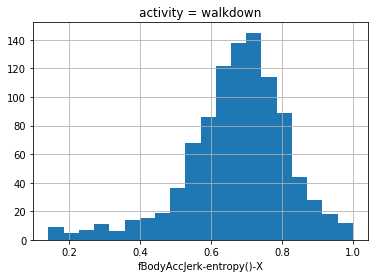

In [9]:
bins, counts = df_walkdown.select('fBodyAccJerk-entropy()-X').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid()
plt.xlabel('fBodyAccJerk-entropy()-X')
plt.title('activity = walkdown')

Text(0.5, 1.0, 'activity = sitting')

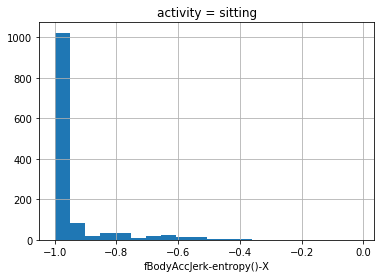

In [10]:
df_sitting = df_data_2.filter(df_data_2['activity']=='sitting')
bins, counts = df_sitting.select('fBodyAccJerk-entropy()-X').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid()
plt.xlabel('fBodyAccJerk-entropy()-X')
plt.title('activity = sitting')

Text(0.5, 1.0, 'activity = walkup')

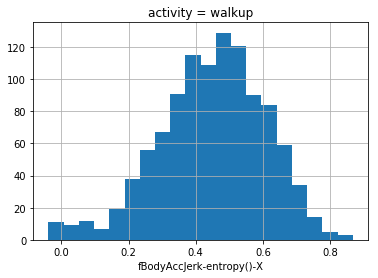

In [11]:
df_walkup = df_data_2.filter(df_data_2['activity']=='walkup')
bins, counts = df_walkup.select('fBodyAccJerk-entropy()-X').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid()
plt.xlabel('fBodyAccJerk-entropy()-X')
plt.title('activity = walkup')

Text(0.5, 1.0, 'activity = standing')

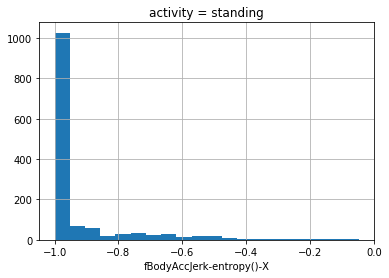

In [12]:
df_standing = df_data_2.filter(df_data_2['activity']=='standing')
bins, counts = df_standing.select('fBodyAccJerk-entropy()-X').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid()
plt.xlabel('fBodyAccJerk-entropy()-X')
plt.title('activity = standing')

Text(0.5, 1.0, 'activity = laying')

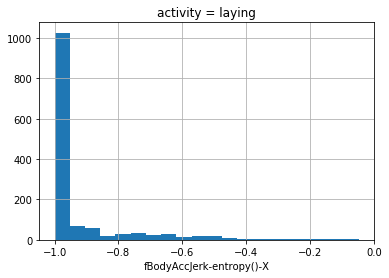

In [13]:
df_laying = df_data_2.filter(df_data_2['activity']=='laying')
bins, counts = df_standing.select('fBodyAccJerk-entropy()-X').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid()
plt.xlabel('fBodyAccJerk-entropy()-X')
plt.title('activity = laying')

Text(0.5, 1.0, 'activity = walk')

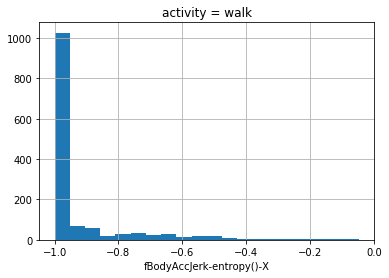

In [14]:
df_walk = df_data_2.filter(df_data_2['activity']=='walk')
bins, counts = df_standing.select('fBodyAccJerk-entropy()-X').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid()
plt.xlabel('fBodyAccJerk-entropy()-X')
plt.title('activity = walk')

In [70]:
from pyspark.sql.functions import when, count, col
df_data_2.select([count(when(col(a).isNull(),a)).alias(a) for a in cols]).show()

+----------------------------------+-------------------------+--------------------------------+-------------------+-------------------------+-----------------+----------------------+-------------------+-----------------+---------------------+---------------------+--------------------------------+---------------------+----------------------+-----------------------------+---------------------------+--------------------+----------------------+-----------------+--------------------------+----------------+-------------------+-------------------------------+--------------------+-----------------------------------+----------------------+-----------------------------------+-----------------------+---------------------+-------------------+-------------------------------+-----------------------------------+-----------------------------------+-----------------------+-----------------------+------------------+-----------------+------------------------+-------------------------------+--------------

scaling

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from pyspark.ml.feature import StandardScaler

featuredX = assembler.transform(df_X)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(featuredX)
scaledX = scalerModel.transform(featuredX)
scaledX.select(["features", "scaledFeatures"]).show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[-0.77111201,-0.9...|[-2.8999272452526...|
|[-0.14992836,-0.9...|[-0.7381387440574...|
|[-0.16564496,-0.9...|[-0.7928342679300...|
|[-0.20718879,-0.9...|[-0.9374114376440...|
|[-0.33952923,-0.9...|[-1.3979709540368...|
+--------------------+--------------------+
only showing top 5 rows



In [73]:
import numpy as np
median_signal = [row['scaledFeatures'] for row in scaledX.collect()]
print("std: " + str(np.std(median_signal)) + " mean: " + str(np.mean(median_signal)))

std: 0.9999319889821361 mean: 4.4212613809833626e-17


std ~ 1, mean ~ 0, so the transformed data has a standard normal distribution

In [10]:
# categorical attribute
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="activity", outputCol="label")
idx_y = indexer.fit(df_y).transform(df_y)
idx_y.select(["activity", "label"]).show(5)

+--------+-----+
|activity|label|
+--------+-----+
|standing|  1.0|
|standing|  1.0|
|standing|  1.0|
|standing|  1.0|
|standing|  1.0|
+--------+-----+
only showing top 5 rows



In [11]:
indexer.fit(df_y).labels

['laying', 'standing', 'sitting', 'walk', 'walkup', 'walkdown']

In [152]:
#pca
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcamodel = pca.fit(scaledX)
pcaresult = pcamodel.transform(scaledX)

In [153]:
print('Explained Variance Ratio', pcamodel.explainedVariance.toArray())

Explained Variance Ratio [0.51 0.07]


In [154]:
X_pca = pcaresult.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [176]:
pandas_y = idx_y.select('label').toPandas()

In [179]:
pdXpca = pd.DataFrame({'PC 1': X_pca[:, 0], 'PC 2': X_pca[:, 1]})

In [182]:
pdXpca['label'] = pandas_y
pdXpca

,PC 1,PC 2,label
0,16.137446,-2.151878,1.0
1,15.295154,-1.387049,1.0
2,15.135989,-2.473183,1.0
3,15.349840,-3.915414,1.0
4,15.543756,-4.598424,1.0
...,...,...,...
7347,-15.464009,12.535453,4.0
7348,-14.221755,10.252804,4.0
7349,-14.332461,12.259878,4.0
7350,-12.875143,14.070299,4.0


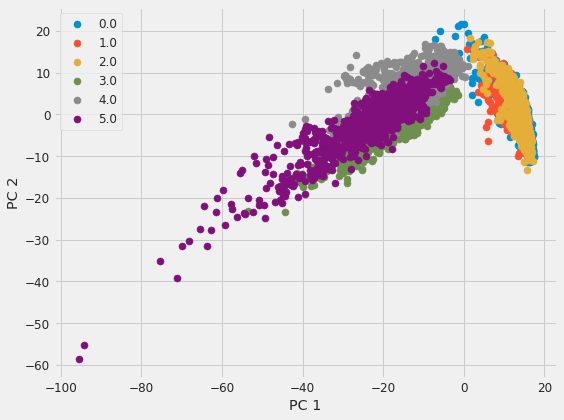

In [190]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

colors = list(plt.rcParams['axes.prop_cycle'])
y = pdXpca['label']
target = np.unique(y)
for idx, t in enumerate(target):
    subset = pdXpca[y == t]
    plt.scatter(subset['PC 1'], subset['PC 2'], s = 50,
                c = colors[idx]['color'], label = t)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [ ]:
scaledX.select('scaledFeatures').toPandas()

In [194]:
from sklearn.manifold import TSNE
tsne = TSNE()
pandas_X = df_X.toPandas()
X_embedded = tsne.fit_transform(pandas_X)

Text(0, 0.5, 't-SNE dimension 2')

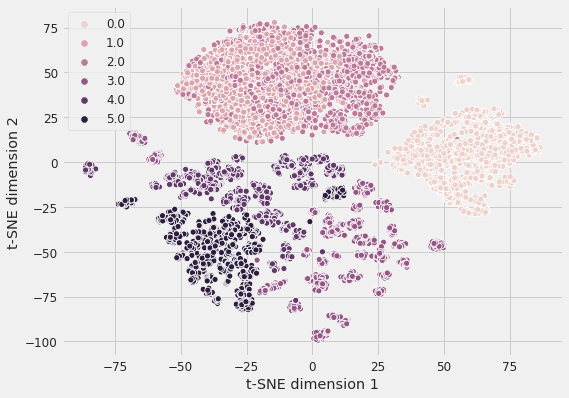

In [200]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=np.ravel(pandas_y), legend='full')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

# Prepare the data for ML

print the number of missing values of each continuous attributes

In [12]:
rawfeatures = list(set(df_data_2.columns) - {'subject'})
df_data = df_data_2.select(rawfeatures)

In [13]:
#pipeline
from pyspark.ml import Pipeline

numPipeline = Pipeline(stages=[assembler, scaler])
catPipeline = Pipeline(stages=[indexer])
pipeline = Pipeline(stages=[numPipeline, catPipeline])
newData = pipeline.fit(df_data).transform(df_data)
#newData.show(1)

In [14]:
va2 = VectorAssembler(inputCols=list(filter(lambda x: x != "activity",newData.columns)), outputCol="final_features")

temp1 = va2.transform(newData)

dataset = temp1.withColumn('features', temp1.final_features).select("features","label")
dataset.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.77111201,-0.9...|  1.0|
|[-0.14992836,-0.9...|  1.0|
|[-0.16564496,-0.9...|  1.0|
|[-0.20718879,-0.9...|  1.0|
|[-0.33952923,-0.9...|  1.0|
+--------------------+-----+
only showing top 5 rows



In [15]:
train, test = dataset.randomSplit([0.7, 0.3], seed=12345)

In [17]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  992|
|  1.0|  959|
|  4.0|  754|
|  3.0|  865|
|  2.0|  873|
|  5.0|  701|
+-----+-----+



train models with all variables

In [16]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [17]:
# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0932971


In [18]:
print('Test accuracy: %g' % accuracy)

Test accuracy: 0.906703


In [21]:
predictions.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       2.0|  2.0|[-0.99960412,-0.9...|
|       2.0|  2.0|[-0.99957358,-0.9...|
|       2.0|  2.0|[-0.99950482,-0.9...|
|       2.0|  2.0|[-0.99933161,-0.9...|
|       2.0|  2.0|[-0.99915736,-0.9...|
+----------+-----+--------------------+
only showing top 5 rows



In [28]:
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [42]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

#print(metrics.confusionMatrix().toArray())

In [37]:
import numpy as np 
import itertools

Normalized confusion matrix
[[0.98 0.02 0.   0.   0.   0.  ]
 [0.   0.87 0.12 0.   0.   0.  ]
 [0.03 0.11 0.85 0.   0.01 0.  ]
 [0.   0.   0.   0.97 0.02 0.  ]
 [0.   0.   0.   0.07 0.89 0.03]
 [0.   0.   0.   0.04 0.06 0.9 ]]


<Figure size 432x288 with 0 Axes>

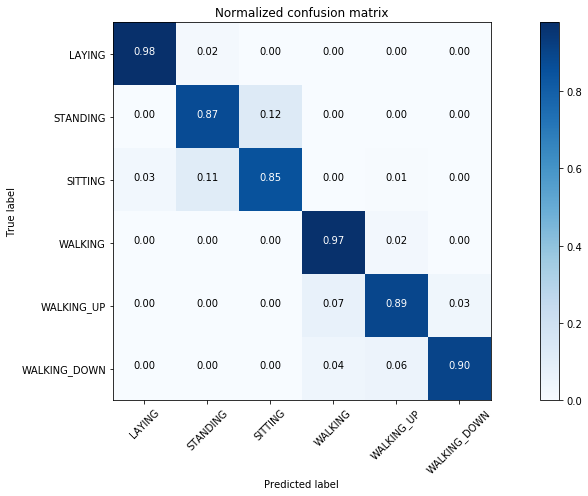

In [44]:
# Compute confusion matrix
cnf_matrix = metrics.confusionMatrix().toArray()
np.set_printoptions(precision=2)

# Plot confusion matrix for lg
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['LAYING', 'STANDING', 'SITTING', 'WALKING', 'WALKING_UP', 'WALKING_DOWN'], title='Normalized confusion matrix')
#'laying', 'standing', 'sitting', 'walk', 'walkup', 'walkdown'
plt.show()

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [59]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
# Train model.  This also runs the indexers.
model = rf.fit(train)
# Make predictions.
predictions = model.transform(test)
# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       2.0|  2.0|[-0.99960412,-0.9...|
|       2.0|  2.0|[-0.99957358,-0.9...|
|       2.0|  2.0|[-0.99950482,-0.9...|
|       2.0|  2.0|[-0.99933161,-0.9...|
|       2.0|  2.0|[-0.99915736,-0.9...|
+----------+-----+--------------------+
only showing top 5 rows



In [57]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0597826


In [73]:
print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.940217


Normalized confusion matrix
[[0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.9  0.1  0.   0.   0.  ]
 [0.   0.08 0.92 0.   0.   0.  ]
 [0.   0.   0.   0.95 0.03 0.01]
 [0.   0.   0.   0.03 0.95 0.02]
 [0.   0.   0.   0.05 0.04 0.92]]


<Figure size 576x432 with 0 Axes>

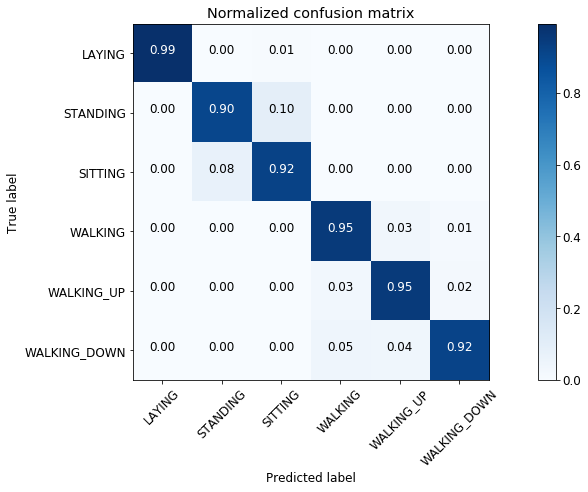

In [58]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

cnf_matrix = metrics.confusionMatrix().toArray()
np.set_printoptions(precision=2)

# Plot confusion matrix for RF
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['LAYING', 'STANDING', 'SITTING', 'WALKING', 'WALKING_UP', 'WALKING_DOWN'], title='Normalized confusion matrix')
#'laying', 'standing', 'sitting', 'walk', 'walkup', 'walkdown'
plt.show()

In [33]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [4, 5, 4, 6]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
model = mlp.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Test Accuracy = 0.906703
Test Error = 0.0932971


In [38]:
from pyspark.ml.classification import LinearSVC
# instantiate the base classifier.
lsvc = LinearSVC(maxIter=50, regParam=0.1)
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lsvc)
# train the multiclass model.
ovrModel = ovr.fit(train)
# score the model on test data.
predictions = ovrModel.transform(test)
# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy: %g' % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Test Accuracy: 0.95788
Test Error = 0.0421196


Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   0.91 0.09 0.   0.   0.  ]
 [0.01 0.11 0.88 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.01 0.98 0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


<Figure size 432x288 with 0 Axes>

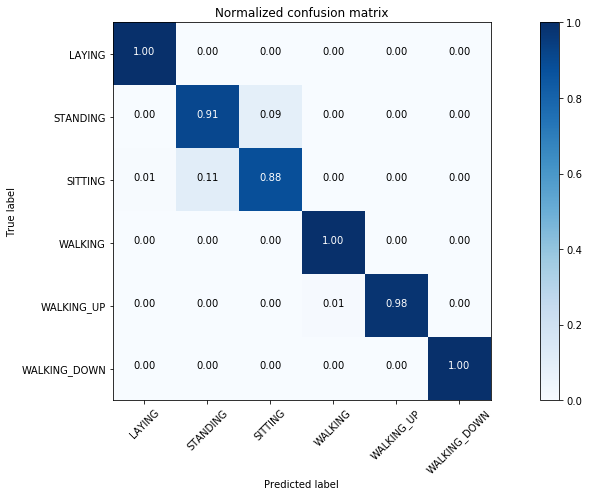

In [39]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

cnf_matrix = metrics.confusionMatrix().toArray()
np.set_printoptions(precision=2)

# Plot confusion matrix for RF
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['LAYING', 'STANDING', 'SITTING', 'WALKING', 'WALKING_UP', 'WALKING_DOWN'], title='Normalized confusion matrix')
#'laying', 'standing', 'sitting', 'walk', 'walkup', 'walkdown'
plt.show()

# hyperparameter tuning 

In [47]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
rf = RandomForestClassifier()
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [1, 5, 10, 15, 20]).addGrid(rf.maxDepth, [5, 10, 15]).build()
cv =  CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy: %g' % accuracy)

Test Accuracy: 1


# feature selection

In [60]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors


selector = ChiSqSelector(numTopFeatures=1, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="label")

result = selector.fit(train).transform(train)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()


ChiSqSelector output with top 1 features selected
+--------------------+-----+----------------+
|            features|label|selectedFeatures|
+--------------------+-----+----------------+
|[-0.99981405,-0.9...|  0.0|   [-0.99396928]|
|[-0.99977796,-0.9...|  2.0|   [-0.99673176]|
|[-0.99972792,-0.9...|  0.0|   [-0.99396928]|
|[-0.99971636,-0.9...|  2.0|   [-0.99801439]|
|[-0.99950847,-0.9...|  2.0|   [-0.99214589]|
|[-0.99930969,-0.9...|  2.0|    [-0.9948629]|
|[-0.99930902,-0.9...|  2.0|   [-0.99334732]|
|[-0.99930533,-0.9...|  0.0|   [-0.99468816]|
|[-0.99927891,-0.9...|  2.0|   [-0.99295004]|
|[-0.99923886,-0.9...|  2.0|    [-0.9937379]|
|[-0.99918853,-0.9...|  2.0|   [-0.99265749]|
|[-0.99907378,-0.9...|  2.0|   [-0.99214589]|
|[-0.99906802,-0.9...|  2.0|   [-0.99464512]|
|[-0.99895886,-0.9...|  2.0|    [-0.9945975]|
|[-0.99893117,-0.9...|  2.0|   [-0.99467035]|
|[-0.99885537,-0.9...|  0.0|   [-0.99581698]|
|[-0.99885506,-0.9...|  0.0|   [-0.99597001]|
|[-0.99882401,-0.9...|  2.0|  

In [52]:
from pyspark.ml.feature import VectorIndexer
featuredData= assembler.transform(df_data)
labelIndexer = StringIndexer(inputCol="activity", outputCol="indexedLabel").fit(featuredData)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(featuredData)
(trainingData, testData) = featuredData.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=18)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])
modelrfImp = pipeline.fit(trainingData)

In [44]:
import pandas as pd
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [62]:
varlist = ExtractFeatureImp(modelrfImp.stages[-1].featureImportances, modelrfImp.transform(trainingData), "features").head(20)

In [63]:
varlist

,idx,name,score
261,261,tGravityAcc-energy()-Y,0.050050
554,554,tGravityAcc-max()-X,0.036327
442,442,tGravityAcc-min()-X,0.035302
379,379,tGravityAcc-max()-Y,0.034626
426,426,tGravityAcc-mean()-X,0.032726
235,235,tBodyAccJerk-entropy()-Z,0.029911
10,10,tGravityAcc-energy()-X,0.027442
278,278,"fBodyAcc-bandsEnergy()-1,8302",0.026644
13,13,tGravityAcc-mean()-Y,0.026578
14,14,fBodyAcc-mad()-X,0.021447


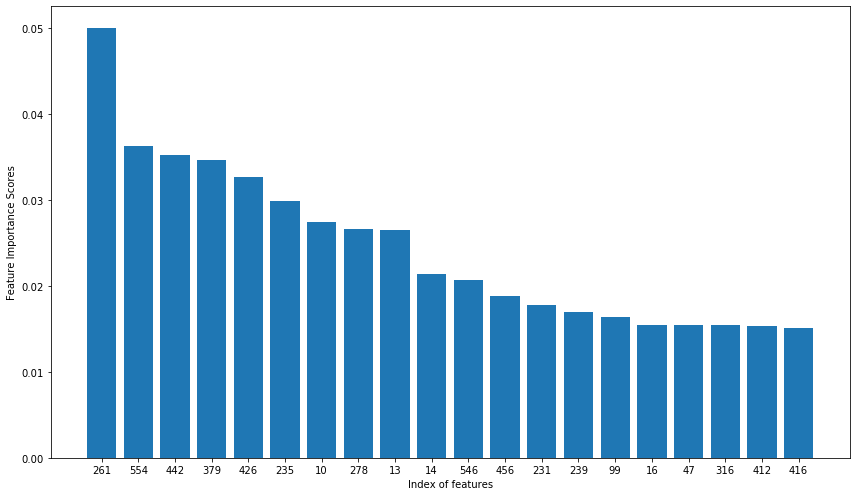

In [72]:
plt.figure(figsize=(12,7))
plt.xlabel('Index of features')
plt.ylabel('Feature Importance Scores')
plt.bar(varlist['name'], varlist['score'])
plt.xticks(varlist['name'], varlist['idx'])
plt.show()

In [77]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import Row
selectidx = [261,554,442,379,426,235,10,278,13,14,546,456,231,239,99,16,47,316,412,416]
slicer = VectorSlicer(inputCol="features", outputCol="userfeatures", indices=[261,554])

output = slicer.transform(train)

output.select("features", "userfeatures").show(1)

+--------------------+--------------------+
|            features|        userfeatures|
+--------------------+--------------------+
|[-0.92338795,-0.9...|[-0.94011832,0.84...|
+--------------------+--------------------+
only showing top 1 row



In [85]:
output.show()

+--------------------+-----+--------------------+
|            features|label|        userfeatures|
+--------------------+-----+--------------------+
|[-0.92338795,-0.9...|  1.0|[-0.94011832,0.84...|
|[-0.77111201,-0.9...|  1.0|[-0.97090521,0.89...|
|[-0.68189445,-0.9...|  0.0|[0.24190815,-0.27...|
|[-0.66944889,-0.9...|  0.0|[-0.63694871,-0.1...|
|[-0.6365034,-0.91...|  1.0|[-0.95513384,0.86...|
|[-0.5993335,-0.99...|  0.0|[-0.38963132,-0.2...|
|[-0.59180224,-0.9...|  0.0|[0.7294021,-0.180...|
|[-0.59044942,-0.9...|  0.0|[0.22980346,-0.27...|
|[-0.58346139,-0.9...|  1.0|[-0.88237099,0.87...|
|[-0.58268078,-0.9...|  0.0|[0.77969549,-0.35...|
|[-0.57627848,-0.9...|  1.0|[-0.88526668,0.87...|
|[-0.54697454,-0.9...|  0.0|[0.26331397,-0.26...|
|[-0.54688246,-0.9...|  0.0|[-0.44094522,-0.3...|
|[-0.53461288,-0.9...|  0.0|[0.33989126,-0.53...|
|[-0.53010012,-0.9...|  0.0|[0.65612647,-0.28...|
|[-0.5237652,-0.99...|  1.0|[-0.91322211,0.80...|
|[-0.51961201,-0.9...|  2.0|[-0.56601145,0.52...|


In [99]:
selectidx = [261,554,442,379,426,235,10,278,13,14,546,456,231,239,99,16,47,316,412,416]
acc=[]
for i in range(1,len(selectidx)+1):
    slicer = VectorSlicer(inputCol="features", outputCol="userfeatures", indices=selectidx[0:i])
    slicedtrain = slicer.transform(train)
    slicedtest = slicer.transform(test)
    rf = RandomForestClassifier(labelCol="label", featuresCol="userfeatures", numTrees=10)
    model = rf.fit(slicedtrain)
    predictions = model.transform(slicedtest)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)

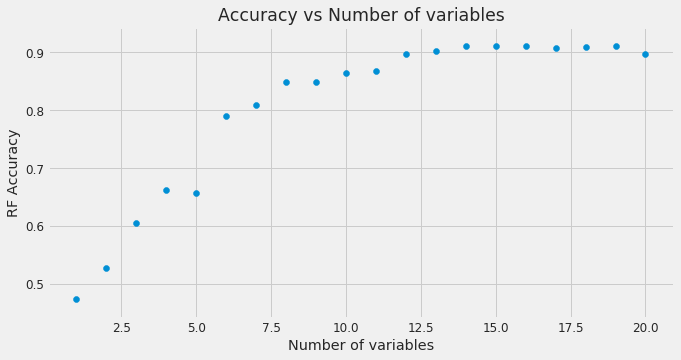

In [204]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(1,len(selectidx)+1), acc)
plt.title('Accuracy vs Number of variables')
plt.xlabel('Number of variables')
plt.ylabel('RF Accuracy')
plt.show()

In [201]:
selectidx = [261,554,442,379,426,235,10,278,13,14,546,456,231,239,99,16,47,316,412,416]
acc_tree=[]
slicer = VectorSlicer(inputCol="features", outputCol="userfeatures", indices=selectidx[0:14])
slicedtrain = slicer.transform(train)
slicedtest = slicer.transform(test)
for i in range(5,100,5):
    rf = RandomForestClassifier(labelCol="label", featuresCol="userfeatures", numTrees=i)
    model = rf.fit(slicedtrain)
    predictions = model.transform(slicedtest)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc_tree.append(accuracy)

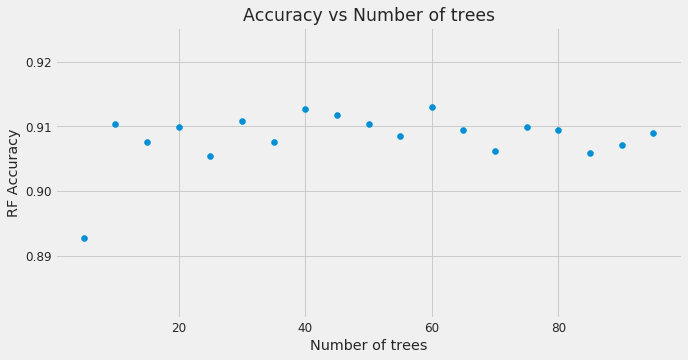

In [205]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(5,100,5), acc_tree)
plt.title('Accuracy vs Number of trees')
plt.xlabel('Number of trees')
plt.ylabel('RF Accuracy')
plt.show()

In [116]:
#choose 15 features and 60 trees
slicer = VectorSlicer(inputCol="features", outputCol="userfeatures", indices=selectidx[0:14])
slicedtrain = slicer.transform(train)
slicedtest = slicer.transform(test)
rf = RandomForestClassifier(labelCol="label", featuresCol="userfeatures", numTrees=60)
model = rf.fit(slicedtrain)
predictions = model.transform(slicedtrain)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)    

Test Accuracy = 0.923406


Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   0.87 0.13 0.   0.01 0.  ]
 [0.   0.08 0.92 0.   0.   0.  ]
 [0.   0.   0.   0.95 0.03 0.02]
 [0.   0.   0.   0.03 0.95 0.02]
 [0.   0.   0.   0.13 0.02 0.84]]


<Figure size 432x288 with 0 Axes>

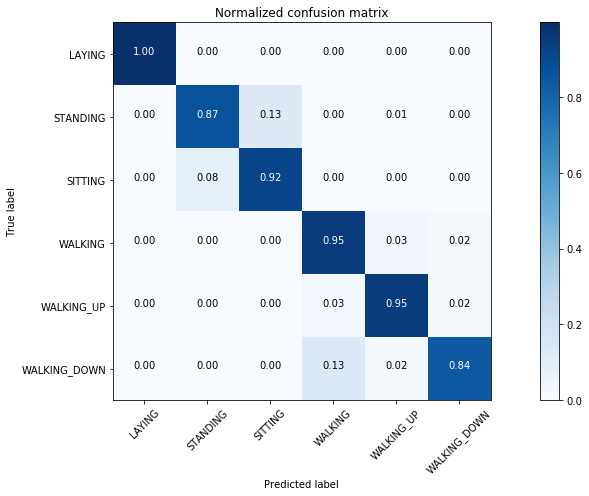

In [117]:
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
cnf_matrix = metrics.confusionMatrix().toArray()
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['LAYING', 'STANDING', 'SITTING', 'WALKING', 'WALKING_UP', 'WALKING_DOWN'], title='Normalized confusion matrix')
plt.show()